In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## KÜTÜPHANELER
Yukarıdaki kodlar, derin öğrenme modelleriyle çalışırken kullanılan birçok temel kütüphaneyi içermektedir. Veri işleme için pandas ve numpy, görselleştirme için matplotlib ve seaborn, görüntü işleme için cv2, makine öğrenmesi modeli eğitimi ve test işlemleri için scikit-learn, derin öğrenme model mimarisi ve işlemleri için tensorflow ve keras kütüphaneleri yüklenmiş. Ayrıca, eğitim sırasında kullanılan ImageDataGenerator ile görüntü verileri genişletilebilir, Adam optimizasyonu öğrenme sürecini optimize eder, EarlyStopping ve ReduceLROnPlateau callback'leri ise modelin aşırı öğrenmesini (overfitting) önlemek ve performansını iyileştirmek için kullanılır. Bu kodlar genel olarak, verileri işleyip derin öğrenme modeliyle sınıflandırma veya tahmin görevlerinde kullanılmak üzere hazırlanmıştır.

In [2]:
directory = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(directory) if '.' not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

## SINIFLANDIRMA
Belirtilen directory dizinindeki alt klasörleri (classes) listeler ve yalnızca dosya olmayan, yani klasör olarak tanımlanan öğeleri filtreler. Dizin içindeki balık veri seti sınıflarını almak için kullanılır. Böylece her klasör, veri setinde yer alan bir balık türünü temsil eder ve bu sınıflar modelde sınıflandırma işlemleri için kullanılabilir.

In [3]:
# Doğru veri seti yolunu tanımlıyoruz
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

label = []
path = []

# os.walk ile dizindeki dosyaları yürüyoruz
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Sadece .png dosyalarını alıyoruz
            if dir_name.split('/')[-1] != 'GT':  # GT dosyalarını dışarıda tutuyoruz
                label.append(os.path.split(dir_name)[-1])  # Klasör adı etiketi belirtiyor
                path.append(os.path.join(dir_name, filename))  # Dosyanın tam yolunu alıyoruz

# DataFrame oluşturma
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label


## VERİTABANI

Verilen balık veri setindeki .png formatındaki görüntüleri ve bunların sınıf etiketlerini toplar. os.walk kullanılarak dizindeki dosyalar taranır, yalnızca görüntü dosyaları ve sınıflandırma için gerekli klasör isimleri (etiketler) toplanır. GT klasörleri (ground truth) hariç tutulur. Toplanan dosya yolları ve etiketler, bir pandas DataFrame içinde organize edilir. Bu yapı, model eğitiminde kullanılacak görüntü verileri ve bunların sınıflandırma etiketlerini içeren bir veri tabanı oluşturur.

In [4]:
data

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
17995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream GT
17996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream GT
17997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream GT
17998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream GT


In [5]:
# İlk satırdaki path'e erişme
print(data['path'][0])

/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png


In [6]:
data.label.value_counts()

label
Hourse Mackerel          1000
Hourse Mackerel GT       1000
Red Sea Bream            1000
Gilt-Head Bream          1000
Gilt-Head Bream GT       1000
Shrimp                   1000
Shrimp GT                1000
Striped Red Mullet       1000
Striped Red Mullet GT    1000
Trout GT                 1000
Trout                    1000
Red Mullet GT            1000
Red Mullet               1000
Sea Bass GT              1000
Sea Bass                 1000
Black Sea Sprat          1000
Black Sea Sprat GT       1000
Red Sea Bream GT         1000
Name: count, dtype: int64

data, DataFrame'inde bulunan etiketlerin (label) kaç kez tekrarlandığını sayar ve her bir sınıfın veri setindeki dağılımını gösterir.

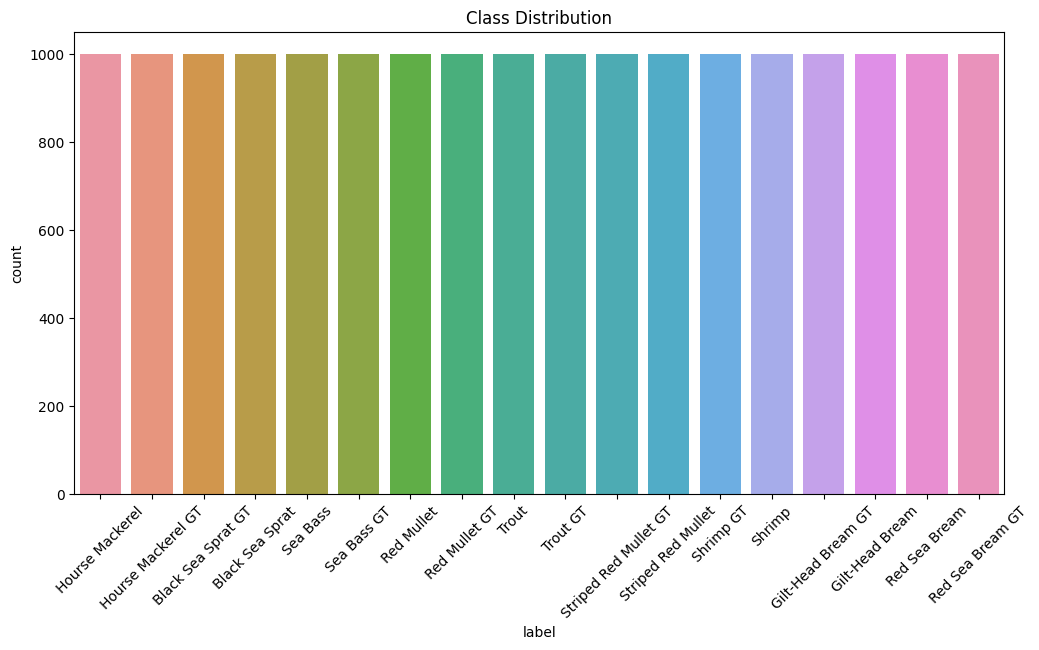

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=data) # x: Classes
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.show()

## MODEL GRAFİĞİ

Balık veri setindeki sınıfların (label) dağılımını görselleştirmek için bir sütun grafiği oluşturur ve sınıflar arasındaki veri dengesizliğini gösterir.

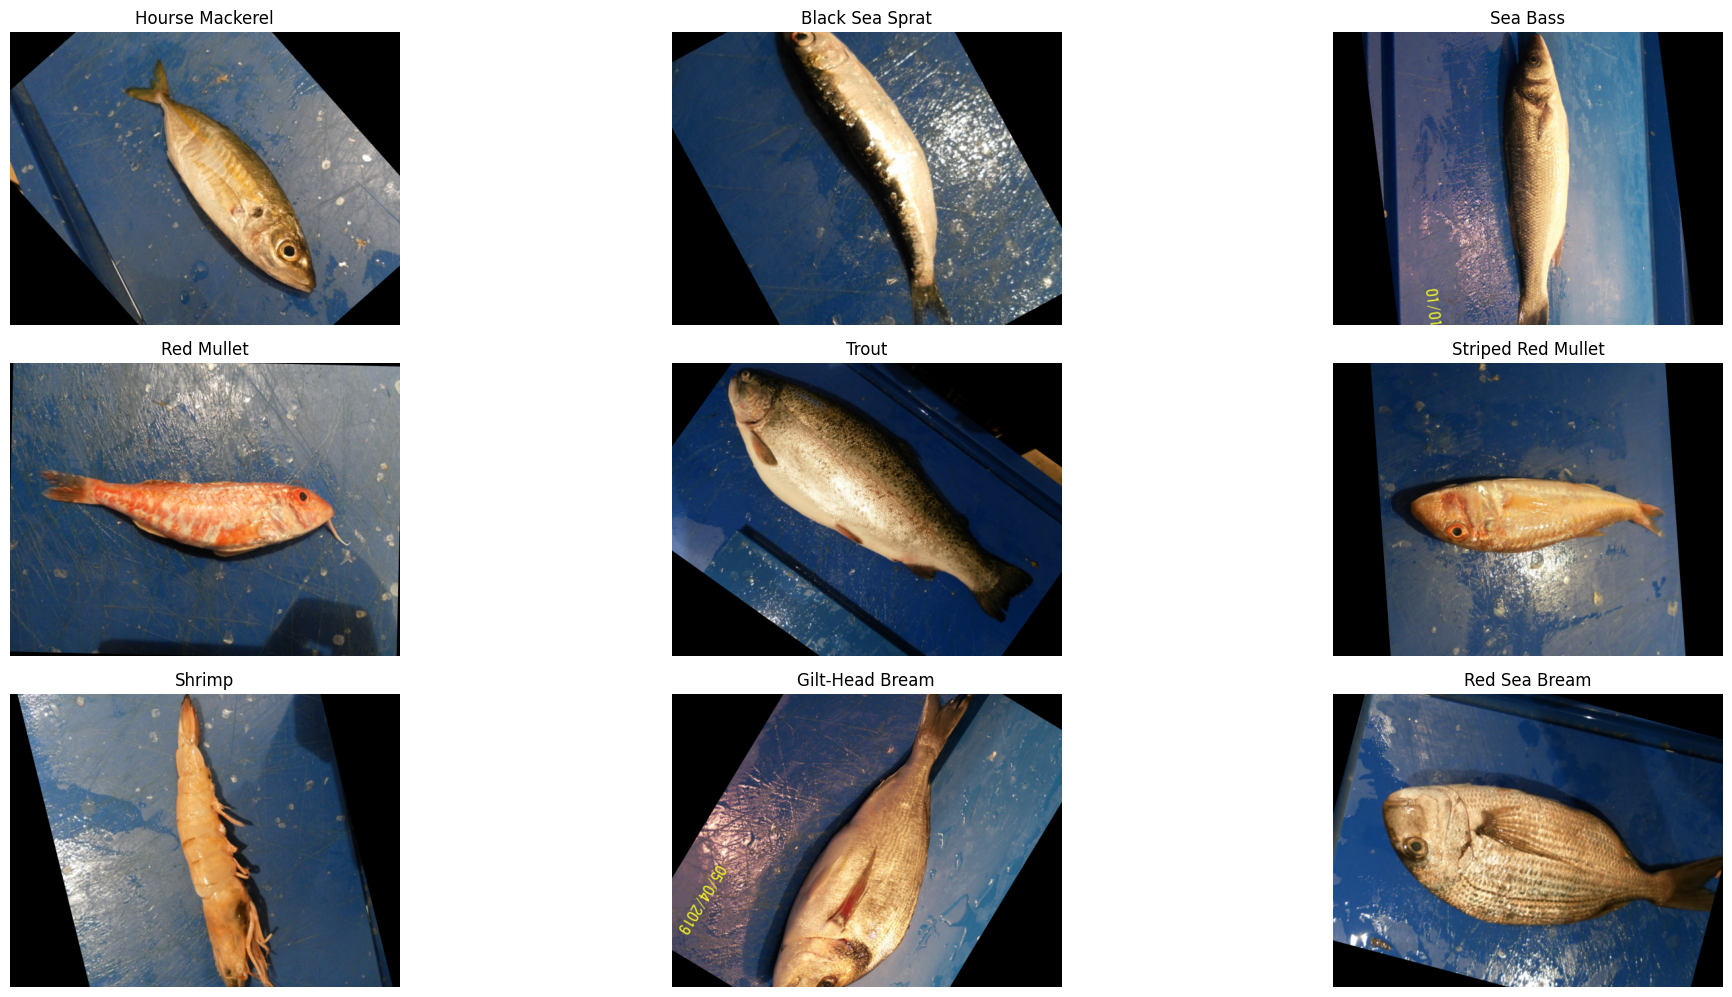

In [8]:
cn = 0
num_classes = len(data['label'].unique())  # Kaç benzersiz etiket olduğunu buluyoruz

# Alt grafik düzenini dinamik olarak ayarlıyoruz (sınıf sayısına göre)
num_cols = 3
num_rows = (num_classes // num_cols) + (num_classes % num_cols > 0)  # Satır sayısını sınıf sayısına göre ayarla

plt.figure(figsize=(20, 20))
for unique_label in data['label'].unique():
    # Sadece "GT" ile bitmeyen görselleri seç
    image_data = data[data['label'] == unique_label]
    non_gt_images = image_data[~image_data['path'].str.contains('GT')]  # GT olmayan görselleri filtrele
    
    if len(non_gt_images) > 0:  # Eğer GT olmayan görseller varsa
        plt.subplot(num_rows, num_cols, cn + 1)  # Satır ve sütunları dinamik hale getirdik
        plt.imshow(plt.imread(non_gt_images.iloc[0, 0]))  # İlk GT olmayan resmi alıyoruz
        plt.title(unique_label)
        plt.axis('off')
        cn += 1

plt.tight_layout()  # Grafiklerin düzenli görünmesi için sıkı yerleşim
plt.show()


## MODEL GÖRÜNTÜLERİ

Balık veri setindeki her sınıftan bir örnek görüntüyü dinamik bir alt grafik düzeninde görselleştirir. İlk olarak, veri setindeki benzersiz etiketlerin sayısı hesaplanır ve ardından bu etiketlere göre satır ve sütun sayıları belirlenir. Her sınıf için "GT" (ground truth) içermeyen görseller filtrelenir ve her sınıftan ilk görsel bir alt grafik içerisinde gösterilir. Grafikler arasında boşlukların düzenli olması için tight_layout kullanılır. Bu görselleştirme, sınıfların görüntü temsillerini hızlıca incelemek için faydalıdır.

In [9]:
# Veriyi eğitim ve test seti olarak ayırıyoruz
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Eğitim ve test setlerinin boyutlarına bakalım
print(f"Eğitim seti boyutu: {train_data.shape[0]}")
print(f"Test seti boyutu: {test_data.shape[0]}")


Eğitim seti boyutu: 14400
Test seti boyutu: 3600


In [10]:
# Veri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_data(fish_dir, img_height, img_width, flatten=True, test_size=0.2):
    
    # Veri arttırma işlemleri ekledim (isteğe bağlı)
    datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=20, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Veri yükleme
    generator = datagen.flow_from_directory(
        fish_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    
    images, labels = [], []
    for i in range(len(generator)):
        batch = next(generator)
        images.append(batch[0])
        labels.append(batch[1])
        if (i + 1) * 32 >= generator.samples:
            break
    
    # Verilerin birleştirilmesi
    X = np.concatenate(images)
    y = np.concatenate(labels)
    
    # Flatten işlemi isteğe bağlı hale getirildi
    if flatten:
        X = X.reshape(X.shape[0], -1)
    
    # Eğitim ve test setlerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Fonksiyonu kullanarak veriyi yükleyelim
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
img_height = 128
img_width = 128

X_train, X_test, y_train, y_test = load_and_preprocess_data(fish_dir, img_height, img_width)

# Eğitim ve test setlerinin boyutlarına bakalım
print(f"Eğitim seti boyutu: {X_train.shape[0]}")
print(f"Test seti boyutu: {X_test.shape[0]}")

Found 18000 images belonging to 9 classes.
Eğitim seti boyutu: 14400
Test seti boyutu: 3600


## VERİ ÖNİŞLEME

Balık veri setini yükleyen ve ön işleme tabi tutan bir fonksiyon içeriyor. Fonksiyonda, görüntü verilerini daha çeşitli hale getirmek için veri arttırma (augmentation) işlemleri eklenmiş (dönme, kaydırma, zoom, yatay çevirme gibi). Görüntüler, ImageDataGenerator kullanılarak yüklenir ve hedef boyutlarda yeniden boyutlandırılır. Daha sonra, bu görüntüler X değişkeninde, etiketler ise y değişkeninde birleştirilir. Eğer belirtilmişse, görüntü verileri düzleştirilir (flatten). Son olarak, veriler eğitim ve test setlerine ayrılır. Kodun sonunda, eğitim ve test setlerinin boyutları ekrana yazdırılır. Bu sayede model eğitimi için gerekli veriler hazırlanmış olur.

In [11]:
# Veri yükleme ve eğitim-test setlerine ayırma
IMG_HEIGHT, IMG_WIDTH = 128, 128
X_train, X_test, y_train, y_test = load_and_preprocess_data(fish_dir, IMG_HEIGHT, IMG_WIDTH)

Found 18000 images belonging to 9 classes.


## VERİ YÜKLEME
Daha önce tanımlanmış load_and_preprocess_data fonksiyonunu kullanarak balık veri setini yükler ve eğitim ile test setlerine ayırır. Görüntüler 128x128 piksel boyutuna yeniden boyutlandırılır ve veri seti eğitim ve test için hazır hale getirilir. Bu ayırma işlemi, modelin eğitilmesi ve test edilmesi için gerekli veri yapısının oluşturulmasını sağlar. Eğitim ve test setlerine ayrılan bu veriler, derin öğrenme modeli ile sınıflandırma işlemlerinde kullanılacaktır.

In [12]:
# Eğitim setini doğrulama (validation) setine ayırıyoruz
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## VERİSET AYIRMA
Eğitim setini doğrulama (validation) setine ayırır. train_test_split fonksiyonu kullanılarak, eğitim verilerinin %20'si doğrulama seti olarak ayrılır. Bu sayede model eğitimi sırasında doğrulama seti ile modelin performansı izlenebilir ve aşırı öğrenme (overfitting) önlenebilir. stratify=y_train ifadesi, sınıf dağılımının hem eğitim hem de doğrulama setlerinde korunmasını sağlar. Böylece sınıflar arasında dengeli bir dağılım elde edilir.

In [13]:
# StandardScaler kullanarak eğitim ve doğrulama setlerini ölçeklendirme
scaler = StandardScaler()

# Sadece eğitim seti üzerinde fit işlemi yapıyoruz
X_train_scaled = scaler.fit_transform(X_train)

# Doğrulama ve test setini eğitim setine göre dönüştürüyoruz (sadece transform)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Ölçeklendirilmiş verilerin boyutlarına bakalım
print(f"Ölçeklendirilmiş eğitim seti boyutu: {X_train_scaled.shape}")
print(f"Ölçeklendirilmiş doğrulama seti boyutu: {X_val_scaled.shape}")
print(f"Ölçeklendirilmiş test seti boyutu: {X_test_scaled.shape}")

Ölçeklendirilmiş eğitim seti boyutu: (11520, 49152)
Ölçeklendirilmiş doğrulama seti boyutu: (2880, 49152)
Ölçeklendirilmiş test seti boyutu: (3600, 49152)


## ÖLÇEKLEME
StandardScaler kullanarak eğitim, doğrulama ve test setlerini ölçeklendirir. İlk olarak, eğitim seti üzerinde fit_transform işlemi uygulanır, bu sayede eğitim verisinin ortalama ve standart sapması hesaplanarak veriler standart hale getirilir. Daha sonra, doğrulama ve test setleri, eğitim setinde elde edilen bu ölçeklendirme parametrelerine göre dönüştürülür (transform), çünkü bu setler üzerinde sadece transform işlemi yapılması gerekir. Bu ölçeklendirme, modelin daha hızlı ve etkili bir şekilde öğrenmesini sağlar. Son olarak, ölçeklendirilmiş verilerin boyutları ekrana yazdırılarak doğrulama yapılır.

In [5]:
# Modelin girdi boyutu ve sınıf sayısı
input_shape = X_train_scaled.shape[1]
num_classes = y_train.shape[1]

# Modeli oluşturma
model = Sequential([
    Input(shape=(input_shape,)),  # Girdi katmanı
    
    # İlk katmanlar (daha büyük boyutlu katmanlar)
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout oranını %40 yaptık
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    # Orta boyutlu katmanlar
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Dropout oranını %30 yaptık
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Çıkış katmanı
    Dense(num_classes, activation='softmax')  # Çok sınıflı (categorical) çıktı
])

NameError: name 'X_train_scaled' is not defined

## ANN
Çok sınıflı bir sınıflandırma modeli oluşturmak için Keras'ın Sequential modelini kullanır. İlk olarak, modelin giriş boyutu eğitim setine göre belirlenir ve sınıf sayısı çoklu sınıflandırma için ayarlanır. Model, her biri relu aktivasyon fonksiyonu kullanan yoğun (dense) katmanlardan oluşur. İlk katmanlar daha büyük boyutlu (512 ve 256 nöronlu) olup, sonrakiler daha küçük boyutlu (128 ve 64 nöronlu) katmanlardır. Katmanlar arasında, modelin aşırı öğrenmesini önlemek için BatchNormalization ve Dropout (rastgele nöronları devre dışı bırakma) teknikleri uygulanmıştır. Çıkış katmanı ise, çok sınıflı sınıflandırma için softmax aktivasyon fonksiyonu ile çalışır. Bu yapı, modelin esnek ve güçlü bir öğrenme kapasitesine sahip olmasını sağlar.

In [15]:
# Modelin derlenmesi
optimizer = Adam(learning_rate=0.01)  # Optimizasyon için Adam kullanıyoruz
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu
              metrics=['accuracy'])

# Model özetini görmek istiyorum
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,343,241 (96.68 MB)

 Trainable params: 25,341,321 (96.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

## DERLEME

Daha önce oluşturulan modeli derlemek ve özetini görüntülemek için kullanılır. Model, optimizasyon işlemi için Adam algoritmasını kullanır ve öğrenme hızı (learning rate) 0.01 olarak ayarlanmıştır. Kayıp fonksiyonu olarak çok sınıflı sınıflandırmaya uygun olan categorical_crossentropy seçilmiştir. Modelin performansı, doğruluk (accuracy) metriği ile değerlendirilir. Son olarak, model.summary() ile modelin yapısı, katmanları, her katmandaki parametre sayısı ve toplam parametre bilgileri özetlenerek görüntülenir. Bu, modelin yapısını analiz etmek ve doğrulamak için kullanılır.

In [16]:
# Callbacks: Erken durdurma ve öğrenme hızını azaltma
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Modeli eğitirken bu callback'leri kullanacağız
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,  # Eğitim epoch sayısı
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]  # Callbacks'leri burada ekliyoruz
)

Epoch 1/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 100s 268ms/step - accuracy: 0.1778 - loss: 2.2359 - val_accuracy: 0.2441 - val_loss: 1.8384 - learning_rate: 0.0100
Epoch 2/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 96s 266ms/step - accuracy: 0.2365 - loss: 1.9120 - val_accuracy: 0.2590 - val_loss: 1.8203 - learning_rate: 0.0100
Epoch 3/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 143s 268ms/step - accuracy: 0.2520 - loss: 1.8719 - val_accuracy: 0.2903 - val_loss: 1.7771 - learning_rate: 0.0100
Epoch 4/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 123s 341ms/step - accuracy: 0.2659 - loss: 1.8376 - val_accuracy: 0.2868 - val_loss: 1.7762 - learning_rate: 0.0100
Epoch 5/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 99s 276ms/step - accuracy: 0.2905 - loss: 1.7935 - val_accuracy: 0.3274 - val_loss: 1.6659 - learning_rate: 0.0100
Epoch 6/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 100s 279ms/step - accuracy: 0.3101 - loss: 1.7413 - val_accuracy: 0.3403 - val_loss: 1.6453 - learning_rate: 0.0100
Epoch 7/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 98s 272ms/step - ac

## EĞİTİM

Model eğitiminde erken durdurma (early stopping) ve öğrenme hızını azaltma (learning rate reduction) callback'lerini kullanarak modeli optimize eder. EarlyStopping, doğrulama kaybı (val_loss) 10 epoch boyunca iyileşmezse eğitimi durdurur ve en iyi ağırlıkları geri yükler. ReduceLROnPlateau ise doğrulama kaybı 5 epoch boyunca iyileşmezse öğrenme hızını 0.2 oranında azaltır, ancak öğrenme hızı 0.00001'den daha düşük olamaz. Model, 100 epoch boyunca eğitilir ve her epoch'ta 32 örnekten oluşan bir batch kullanılır. validation_data argümanı doğrulama seti ile modelin performansını izler. Bu callback'ler, aşırı öğrenmeyi (overfitting) önlemeye ve modelin genel performansını iyileştirmeye yardımcı olur.

In [17]:
# Model değerlendirme
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4492 - loss: 1.4048
Test accuracy: 0.4342


## DOĞRULUK

Eğitilen modelin test verileri üzerinde performansını değerlendirir. model.evaluate() fonksiyonu, test verisi (X_test_scaled) ve gerçek etiketler (y_test) kullanarak modelin kaybını (test_loss) ve doğruluğunu (test_accuracy) hesaplar. Sonuç olarak, test seti üzerindeki doğruluk değeri ekrana yazdırılır. Bu işlem, modelin gerçek veriler üzerindeki genel başarı seviyesini değerlendirmek ve öğrenme sürecinin ne kadar etkili olduğunu görmek için kullanılır.

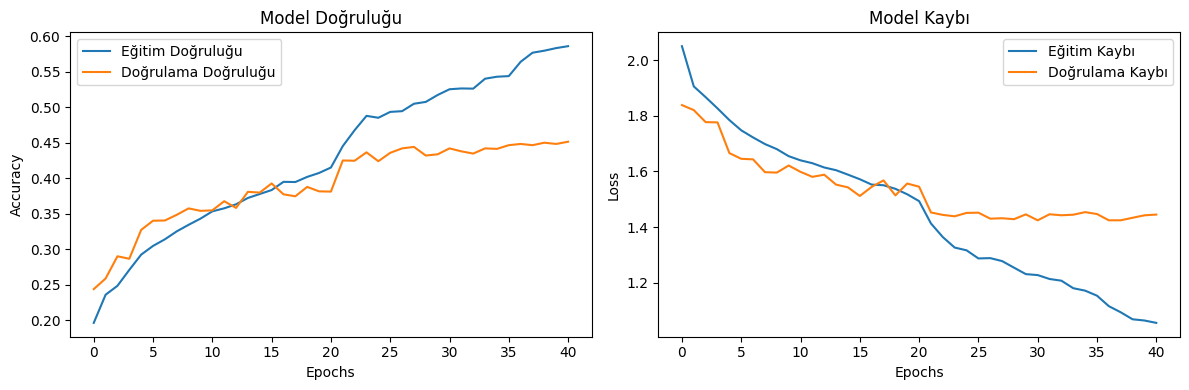

In [18]:
# Eğitim süreci görselleştirme
plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')  # Training Accuracy
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')  # Validation Accuracy
plt.legend()
plt.title('Model Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')  # Training Loss
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')  # Validation Loss
plt.legend()
plt.title('Model Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()  # Grafikler arası boşlukları düzgünleştirir
plt.show()

## GRAFİKLE GÖRSELLEŞTİRME
Modelin eğitim sürecindeki doğruluk ve kayıp değerlerini görselleştirir. plt.subplot ile iki grafik oluşturulur: birinci grafik, eğitim doğruluğu ve doğrulama doğruluğunun epoch'lara göre nasıl değiştiğini gösterir; ikinci grafik ise eğitim kaybı ve doğrulama kaybını karşılaştırır. Bu görselleştirme, modelin zaman içindeki performansını takip etmek ve aşırı öğrenme (overfitting) olup olmadığını anlamak için kullanılır. Ayrıca, plt.tight_layout() fonksiyonu ile grafiklerin arasındaki boşluklar optimize edilir, böylece grafikler düzenli ve okunabilir hale getirilir.

In [4]:

# Tahmin fonksiyonunu tanımlıyoruz
def make_predictions(model, X_test_scaled):
    predictions = model.predict(X_test_scaled)  # Test verileri üzerinde tahmin yapma işlemi
    return np.argmax(predictions, axis=1)  # Her tahmin için en yüksek olasılığa sahip sınıfı alma işlemi

# Test seti üzerindeki tahminler
y_pred = make_predictions(model, X_test_scaled)

# Sınıflandırma raporu
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion matrix
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))


NameError: name 'model' is not defined

## TAHMİN

Test verileri üzerinde model tahminlerini yaparak sonuçları değerlendirir. make_predictions fonksiyonu, modelin test verileri (X_test_scaled) üzerindeki tahminlerini yapar ve her tahmin için en yüksek olasılığa sahip sınıfı döndürür. Ardından, classification_report ile modelin sınıf bazında performansı (doğruluk, hatırlama, F1 skoru) hesaplanır. Son olarak, confusion_matrix ile modelin hangi sınıflarda doğru ve yanlış tahminler yaptığına dair karışıklık matrisi (confusion matrix) oluşturulur. Bu değerlendirme metrikleri, modelin doğruluğunu ve sınıflar arası performansını detaylı bir şekilde analiz etmeye olanak sağlar.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    """
    Confusion matrix'i oluşturur ve görselleştirir.
    :param y_true: Gerçek sınıflar (one-hot encoded olmayan, düz sınıflar)
    :param y_pred: Tahmin edilen sınıflar (düz sınıflar)
    :param class_labels: Sınıf isimlerini içeren liste
    """
    # Confusion matrix oluşturma
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Confusion matrix'i görselleştirme
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Tahmin Edilen Sınıflar')  # Predicted Labels
    plt.ylabel('Gerçek Sınıflar')  # True Labels
    plt.title('Confusion Matrix')
    plt.show()

# Test seti üzerindeki tahminler (önceki kodda tahmin fonksiyonunu kullanabiliriz)
y_pred = make_predictions(model, X_test_scaled)

# Gerçek sınıfları one-hot encoded'dan düz sınıflara çevirme
y_true = np.argmax(y_test, axis=1)

# Sınıf etiketlerini belirleme
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Sınıf etiketlerini buraya ekle

# Confusion matrix'i çizme
plot_confusion_matrix(y_true, y_pred, class_labels)

# SINIF PERFORMANSI
Tahmin edilen ve gerçek sınıflar arasındaki karışıklıkları görselleştirmek için bir karışıklık matrisi (confusion matrix) oluşturur ve çizer. İlk olarak, confusion_matrix fonksiyonu kullanılarak tahmin edilen sınıflar ve gerçek sınıflar karşılaştırılır. Sonrasında, sns.heatmap kullanılarak bir ısı haritası şeklinde karışıklık matrisi görselleştirilir. Gerçek ve tahmin edilen sınıflar, eksen etiketleri ile belirtilir. Bu matriks, modelin hangi sınıflarda doğru ve yanlış tahminler yaptığını analiz etmek için kullanılır. Kod, sınıf bazında modelin performansını görselleştirir.

In [ ]:
def plot_random_predictions(X_test_scaled, y_test, y_pred, num_samples, img_height, img_width, classes):
    """
    Rastgele num_samples kadar test örneği seçip, model tahminlerini görselleştirir.
    :param X_test_scaled: Ölçeklenmiş test verileri
    :param y_test: Test seti etiketleri (gerçek sınıflar, one-hot encoded)
    :param y_pred: Modelin tahmin ettiği sınıflar (integer)
    :param num_samples: Görselleştirilecek örnek sayısı
    :param img_height: Görüntü yüksekliği
    :param img_width: Görüntü genişliği
    :param classes: Sınıf isimlerinin listesi
    """
    
    # Her satırda gösterilecek maksimum görsel sayısı
    num_cols = 5  
    num_rows = (num_samples + num_cols - 1) // num_cols  # Yuvarlama yerine daha kısa bir hesaplama

    # Rastgele num_samples kadar indeks seçimi
    random_indices = np.random.choice(len(X_test_scaled), num_samples, replace=False)

    # Alt grafik düzeni oluşturma (num_rows x num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), subplot_kw={'xticks': [], 'yticks': []})

    # Subplotlar arasında boş kalırsa, eksik olanları gizle
    axes = axes.flatten()

    # Her bir subplot için döngü
    for i, idx in enumerate(random_indices):
        ax = axes[i]

        # Görseli yeniden şekillendir ve göster
        ax.imshow(X_test_scaled[idx].reshape(img_height, img_width, 3))

        # Gerçek sınıf ve tahmin edilen sınıfı al
        true_label = classes[np.argmax(y_test[idx])]
        predicted_label = classes[y_pred[idx]]

        # Tahmin doğruysa başlık yeşil, yanlışsa kırmızı olacak şekilde ayarla
        color = 'green' if true_label == predicted_label else 'red'

        # Başlığı ekle
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

    # Boş kalan subplot'ları gizle (eğer num_samples, num_cols x num_rows'dan küçükse)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Grafik düzenini sıkıştır
    plt.show()  # Grafiği göster


## DOĞRU-YANLIŞ TESPİTİ
Test verilerinden rastgele seçilen örneklerin gerçek sınıfları ve modelin tahmin ettiği sınıfları görselleştirir. Fonksiyon, num_samples kadar rastgele test örneği seçer ve her örneği alt grafiklerde gösterir. Görüntüler yeniden şekillendirilir ve doğru tahmin edilenler yeşil başlıkla, yanlış tahmin edilenler ise kırmızı başlıkla işaretlenir. Alt grafik düzeni, örnek sayısına göre dinamik olarak ayarlanır ve boş kalan alanlar gizlenir. Bu görselleştirme, modelin tahmin performansını ve hangi örneklerde hata yaptığını görsel olarak analiz etmek için kullanılır.

In [ ]:
# Modelin test seti üzerindeki tahminleri (argmax ile sınıf değerlerini alıyoruz)
y_pred = make_predictions(model, X_test_scaled)

# Gerçek etiketleri argmax ile düz sınıflara çevirme
y_true = np.argmax(y_test, axis=1)

# Sınıf isimlerini belirleme (örneğin, ['Kedi', 'Köpek', 'Kuş'] gibi)
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Kendi sınıf etiketlerini eklemeyi unutma

# Rastgele tahminleri görselleştir
plot_random_predictions(X_test_scaled, y_true, y_pred, num_samples=10, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, classes=class_labels)


## PERFORMANS ANALİZİ
Modelin test seti üzerindeki tahminlerini alarak rastgele 10 adet örneği görselleştirir. make_predictions fonksiyonu kullanılarak modelin tahmin ettiği sınıf etiketleri (argmax ile) elde edilir. y_test'in gerçek etiketleri de argmax ile düz sınıflara dönüştürülür. Sınıf isimleri (örneğin, ['Class 1', 'Class 2', 'Class 3']) tanımlandıktan sonra, plot_random_predictions fonksiyonu çağrılarak bu sınıfların rastgele örnekleri test verilerinden seçilip, doğru ve yanlış tahminler görselleştirilir. Bu görselleştirme, modelin sınıflandırma performansını görsel olarak analiz etme imkanı sunar.